In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/My Drive/market

/content/gdrive/My Drive/market


In [ ]:
import pandas as pd

sales = pd.read_csv('sales_train.csv')
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
from datetime import datetime
sales['year'] = pd.to_datetime(sales['date']).dt.strftime('%Y')
sales['month'] = sales.date.apply(lambda x: datetime.strptime(x,'%d.%m.%Y').strftime('%m')) 

sales.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,02.01.2013,0,59,22154,999.0,1.0,2013,01
1,03.01.2013,0,25,2552,899.0,1.0,2013,01


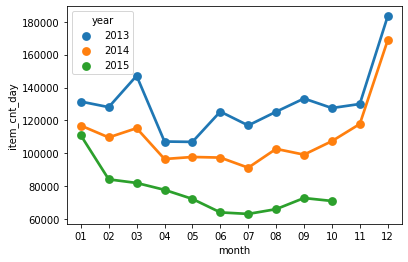

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

grouped = pd.DataFrame(sales.groupby(['year','month'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x='month', y='item_cnt_day', hue='year', data=grouped)

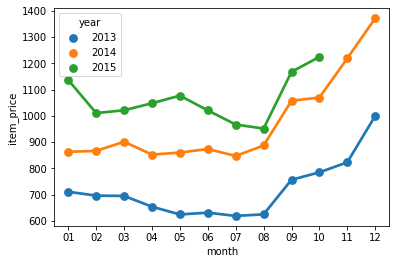

In [ ]:
#Price
grouped_price = pd.DataFrame(sales.groupby(['year','month'])['item_price'].mean().reset_index())
sns.pointplot(x='month', y='item_price', hue='year', data=grouped_price)

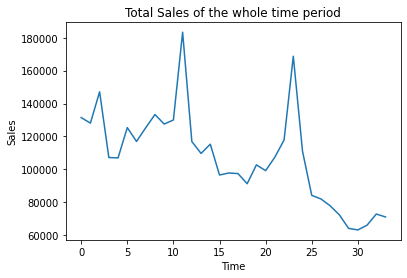

In [ ]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.title('Total Sales of the whole time period')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

In [ ]:
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
# Only shops that exist in test set.
sales = sales[sales['shop_id'].isin(test['shop_id'].unique())]
# Only items that exist in test set.
sales = sales[sales['item_id'].isin(test['item_id'].unique())]

In [ ]:
#column time stamp
pre_df = sales.copy()
pre_df = pre_df.pivot_table(
    index=['shop_id', 'item_id'],
    values=['item_cnt_day'],
    columns=['date_block_num'],
    fill_value=0,
    aggfunc='sum'
).reset_index()

pre_df

shop_id item_id item_cnt_day              ...                     
date_block_num                            0  1  2  3  4  ... 27 28 29 30 31 32 33
0                    2      30            0  0  1  0  0  ...  0  0  0  0  0  0  0
1                    2      31            0  4  1  1  0  ...  0  0  0  0  0  0  1
2                    2      32            0  0  0  0  0  ...  0  0  0  0  1  0  0
3                    2      33            1  0  0  0  0  ...  1  1  0  1  0  1  0
4                    2      53            0  0  0  0  0  ...  0  0  0  0  0  0  0
...                ...     ...          ... .. .. .. ..  ... .. .. .. .. .. .. ..
111399              59   22145            0  0  0  0  0  ...  0  0  0  0  0  0  0
111400              59   22154            1  0  0  0  0  ...  0  0  0  0  0  0  0
111401              59   22162            0  0  0  0  0  ...  1  1  0  0  1  0  0
111402              59   22164            0  0  0  0  0  ...  2  0  0  1  0  0  0
111403              59   22167            0  0  0  0  0  ...  0  0  0  0  0  0  0

[111404 rows x 36 columns]

In [ ]:
full_train_df = test.copy()
full_train_df = full_train_df.merge(pre_df, how='left', on=['shop_id', 'item_id']).fillna(0).drop(
    ['ID', 'shop_id', 'item_id'], axis=1)

full_train_df

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)","(item_cnt_day, 11)","(item_cnt_day, 12)","(item_cnt_day, 13)","(item_cnt_day, 14)","(item_cnt_day, 15)","(item_cnt_day, 16)","(item_cnt_day, 17)","(item_cnt_day, 18)","(item_cnt_day, 19)","(item_cnt_day, 20)","(item_cnt_day, 21)","(item_cnt_day, 22)","(item_cnt_day, 23)","(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train, y_train = full_train_df.values[:,:-2], full_train_df.values[:, -2:-1].ravel()
X_valid, y_valid = full_train_df.values[:,1:-1], full_train_df.values[:, -1:].ravel()
X_test = full_train_df.values[:, 2:]

X_train

array([[0., 0., 0., ..., 1., 1., 3.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 2., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(X_train,axis = 2)

X_valid = np.expand_dims(X_valid,axis = 2)

# for test we keep all the columns execpt the first one
X_test = np.expand_dims(X_test,axis = 2)

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 32, 1) (214200,) (214200, 32, 1)


In [ ]:
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Bidirectional, GRU, Dropout
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError

early_stopping = EarlyStopping(monitor='loss', patience=10, mode='min')

# our defining our model 
my_model = Sequential()
my_model.add(LSTM(units = 64,input_shape = (32,1)))
my_model.add(Dropout(0.4))
my_model.add(Dense(1))

my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mse'])
#my_model.summary()

In [ ]:
my_model.fit(X_train, y_train, batch_size=4096, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=[early_stopping])

Epoch 1/100
53/53 [==============================] - 3s 30ms/step - loss: 5.8033 - mse: 5.8033 - val_loss: 30.3541 - val_mse: 30.3541
Epoch 2/100
53/53 [==============================] - 1s 22ms/step - loss: 4.6092 - mse: 4.6092 - val_loss: 30.0630 - val_mse: 30.0630
Epoch 3/100
53/53 [==============================] - 1s 23ms/step - loss: 6.4690 - mse: 6.4690 - val_loss: 29.8715 - val_mse: 29.8715
Epoch 4/100
53/53 [==============================] - 1s 22ms/step - loss: 6.2840 - mse: 6.2840 - val_loss: 29.7549 - val_mse: 29.7549
Epoch 5/100
53/53 [==============================] - 1s 22ms/step - loss: 6.8463 - mse: 6.8463 - val_loss: 29.6622 - val_mse: 29.6622
Epoch 6/100
53/53 [==============================] - 1s 22ms/step - loss: 4.2940 - mse: 4.2940 - val_loss: 29.5699 - val_mse: 29.5699
Epoch 7/100
53/53 [==============================] - 1s 22ms/step - loss: 4.7902 - mse: 4.7902 - val_loss: 29.4931 - val_mse: 29.4931
Epoch 8/100
53/53 [==============================] - 1s 22ms/s

In [ ]:
# creating submission file 
submission_pfs = my_model.predict(X_test)
# we will keep every value between 0 and 20
submission_pfs = submission_pfs.clip(0,20)
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':submission['ID'],'item_cnt_month':submission_pfs.ravel()})
# creating csv file from dataframe
submission.to_csv('sub_pfs.csv',index = False)